In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report,roc_auc_score
import matplotlib.pyplot as plt

import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
plant_village = '/kaggle/input/plantvillage-dataset/color'

In [3]:
train, test = tf.keras.utils.image_dataset_from_directory(plant_village,
                                                         image_size=(224,224),
                                                         batch_size=32,
                                                         seed=123,
                                                         validation_split=0.2,
                                                         subset='both')

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Using 10861 files for validation.


In [4]:
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 3s 0us/step


In [5]:
for layer in resnet_base.layers:
    layer.trainable = True

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255,input_shape=(224,224,3)),
    
    resnet_base,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(38,activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0

In [8]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=1000,decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [9]:
model.compile(optimizer = optimizer,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 patience = 5,
                                                 restore_best_weights = True)

In [11]:
history = model.fit(train, epochs=8, validation_data=test,callbacks=[early_stopping])

Epoch 1/8
1358/1358 [==============================] - 298s 187ms/step - loss: 1.3377 - accuracy: 0.6485 - val_loss: 1.2115 - val_accuracy: 0.6716
Epoch 2/8
1358/1358 [==============================] - 251s 185ms/step - loss: 0.4082 - accuracy: 0.8832 - val_loss: 0.3477 - val_accuracy: 0.9037
Epoch 3/8
1358/1358 [==============================] - 251s 185ms/step - loss: 0.2423 - accuracy: 0.9309 - val_loss: 0.7186 - val_accuracy: 0.8309
Epoch 4/8
1358/1358 [==============================] - 250s 184ms/step - loss: 0.1685 - accuracy: 0.9528 - val_loss: 0.2890 - val_accuracy: 0.9146
Epoch 5/8
1358/1358 [==============================] - 251s 185ms/step - loss: 0.1285 - accuracy: 0.9635 - val_loss: 0.3978 - val_accuracy: 0.8890
Epoch 6/8
1358/1358 [==============================] - 251s 184ms/step - loss: 0.0889 - accuracy: 0.9755 - val_loss: 0.1369 - val_accuracy: 0.9612
Epoch 7/8
1358/1358 [==============================] - 251s 185ms/step - loss: 0.0664 - accuracy: 0.9829 - val_loss: 0

In [48]:
true_labels = [l for x,l in test.unbatch()]

In [49]:
predictions = model.predict(test)
predicted_labels = tf.argmax(predictions,axis=1)
print(classification_report(true_labels, predicted_labels))

340/340 [==============================] - 19s 55ms/step
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       120
           1       0.99      0.98      0.98       124
           2       1.00      0.82      0.90        56
           3       0.99      1.00      1.00       348
           4       1.00      1.00      1.00       318
           5       1.00      0.94      0.97       208
           6       1.00      1.00      1.00       147
           7       0.88      0.92      0.90       109
           8       1.00      1.00      1.00       238
           9       0.95      0.93      0.94       200
          10       1.00      1.00      1.00       247
          11       0.98      1.00      0.99       229
          12       1.00      0.99      0.99       274
          13       1.00      0.99      0.99       219
          14       0.96      1.00      0.98        94
          15       1.00      0.99      1.00      1137
          16       0.99 

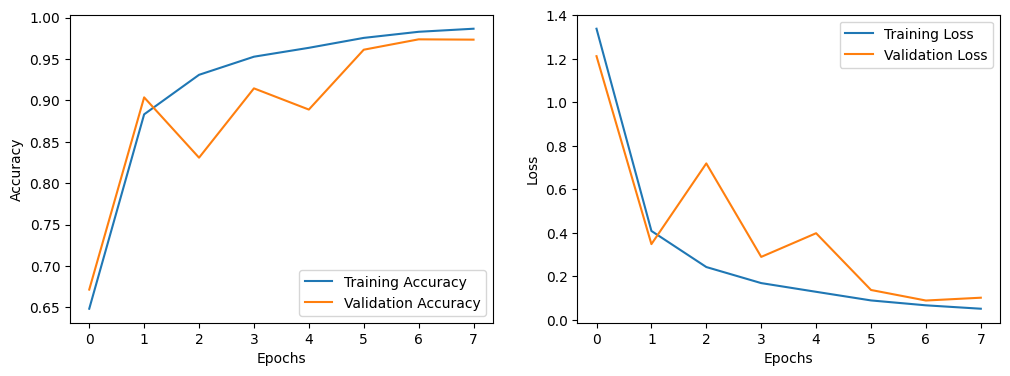

In [50]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [51]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [52]:
tloh = tf.one_hot(true_labels, depth=38)
ploh = tf.one_hot(predicted_labels, depth=38)
roc_auc = roc_auc_score(tloh,ploh, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc)

ROC AUC SCORE:  0.9810311520620248


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer


# Assuming y_train and y_test are TensorFlow datasets
# Convert them to NumPy arrays
y_train_numpy = np.array(list(y_train.as_numpy_iterator()))
y_test_numpy = np.array(list(true_labels.as_numpy_iterator()))

# Use LabelBinarizer
label_binarizer = LabelBinarizer().fit(y_train_numpy)
y_onehot_test = label_binarizer.transform(y_test_numpy)
print(y_onehot_test.shape)

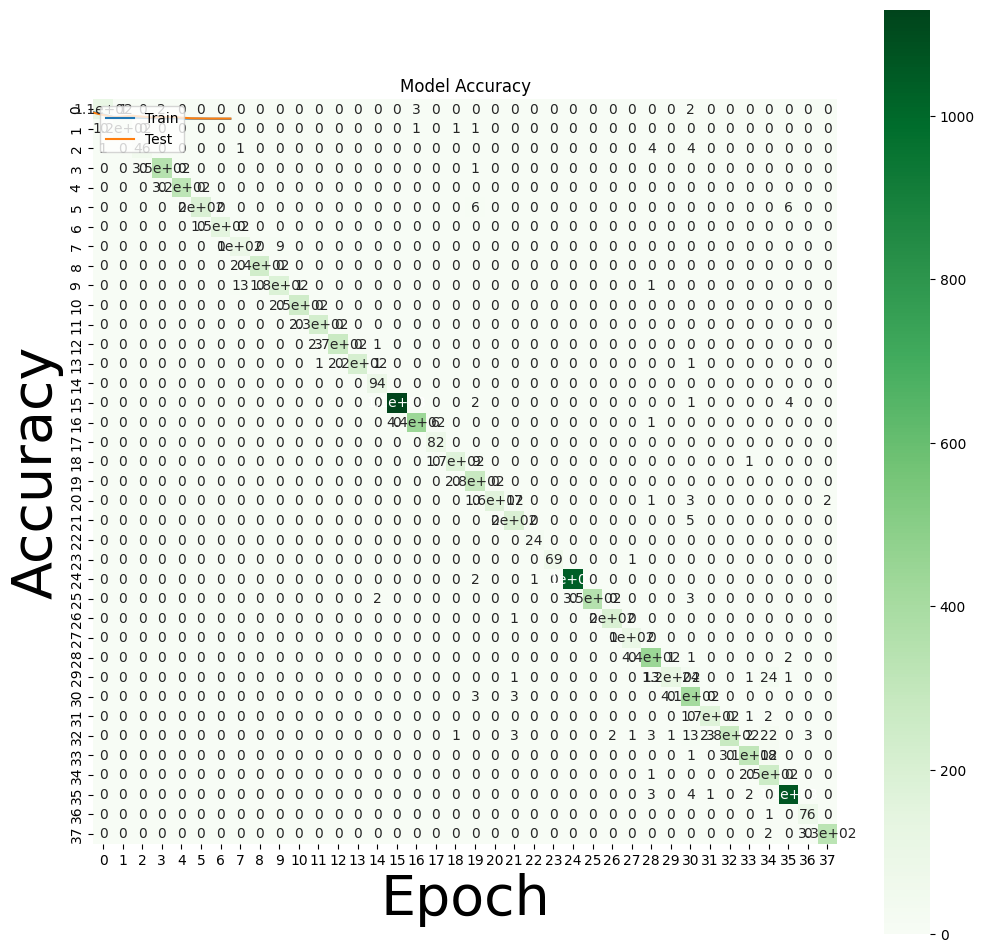

In [66]:
class_names = [i for i in range(38)]
cm = confusion_matrix(true_labels,predicted_labels)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [12]:
model2 = tf.keras.models.clone_model(model)

In [13]:
model2.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001) ,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
history2 = model2.fit(train, epochs=15, validation_data=test,callbacks=[early_stopping],steps_per_epoch = int(0.25*len(train)))

Epoch 1/15
339/339 [==============================] - 113s 231ms/step - loss: 3.2123 - accuracy: 0.2189 - val_loss: 5.5160 - val_accuracy: 0.1382
Epoch 2/15
339/339 [==============================] - 77s 227ms/step - loss: 2.4286 - accuracy: 0.3626 - val_loss: 2.3406 - val_accuracy: 0.3953
Epoch 3/15
339/339 [==============================] - 77s 227ms/step - loss: 2.0308 - accuracy: 0.4403 - val_loss: 2.6845 - val_accuracy: 0.3983
Epoch 4/15
339/339 [==============================] - 77s 227ms/step - loss: 1.8441 - accuracy: 0.4786 - val_loss: 1.9001 - val_accuracy: 0.4930
Epoch 5/15
339/339 [==============================] - 20s 59ms/step - loss: 1.5788 - accuracy: 0.4808 - val_loss: 1.9015 - val_accuracy: 0.4874


In [55]:
predictions2 = model2.predict(test)
predicted_labels2 = tf.argmax(predictions2,axis=1)
print(classification_report(true_labels, predicted_labels2))

340/340 [==============================] - 14s 36ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.00      0.00      0.00       124
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00       348
           4       0.00      0.00      0.00       318
           5       0.00      0.00      0.00       208
           6       0.00      0.00      0.00       147
           7       0.00      0.00      0.00       109
           8       0.00      0.00      0.00       238
           9       0.00      0.00      0.00       200
          10       0.00      0.00      0.00       247
          11       0.00      0.00      0.00       229
          12       0.00      0.00      0.00       274
          13       0.00      0.00      0.00       219
          14       0.00      0.00      0.00        94
          15       0.00      0.00      0.00      1137
          16       0.00 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


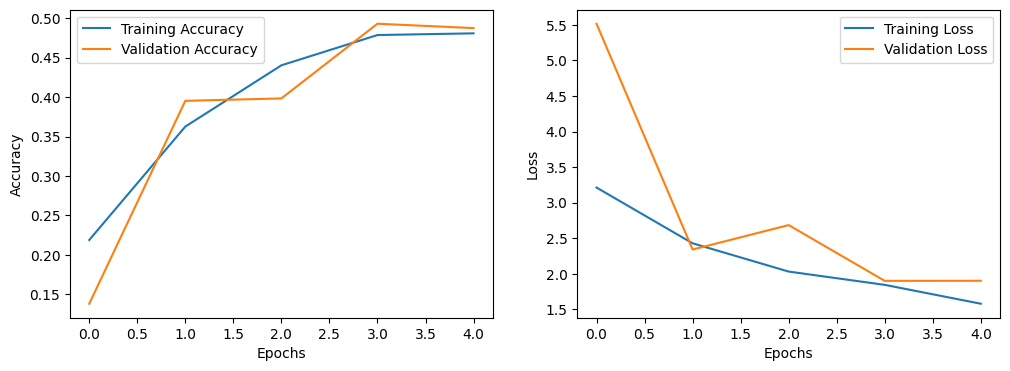

In [56]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [57]:
ploh2 = tf.one_hot(predicted_labels2, depth=38)
roc_auc2 = roc_auc_score(tloh,ploh2, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc2)

ROC AUC SCORE:  0.5000317254556625


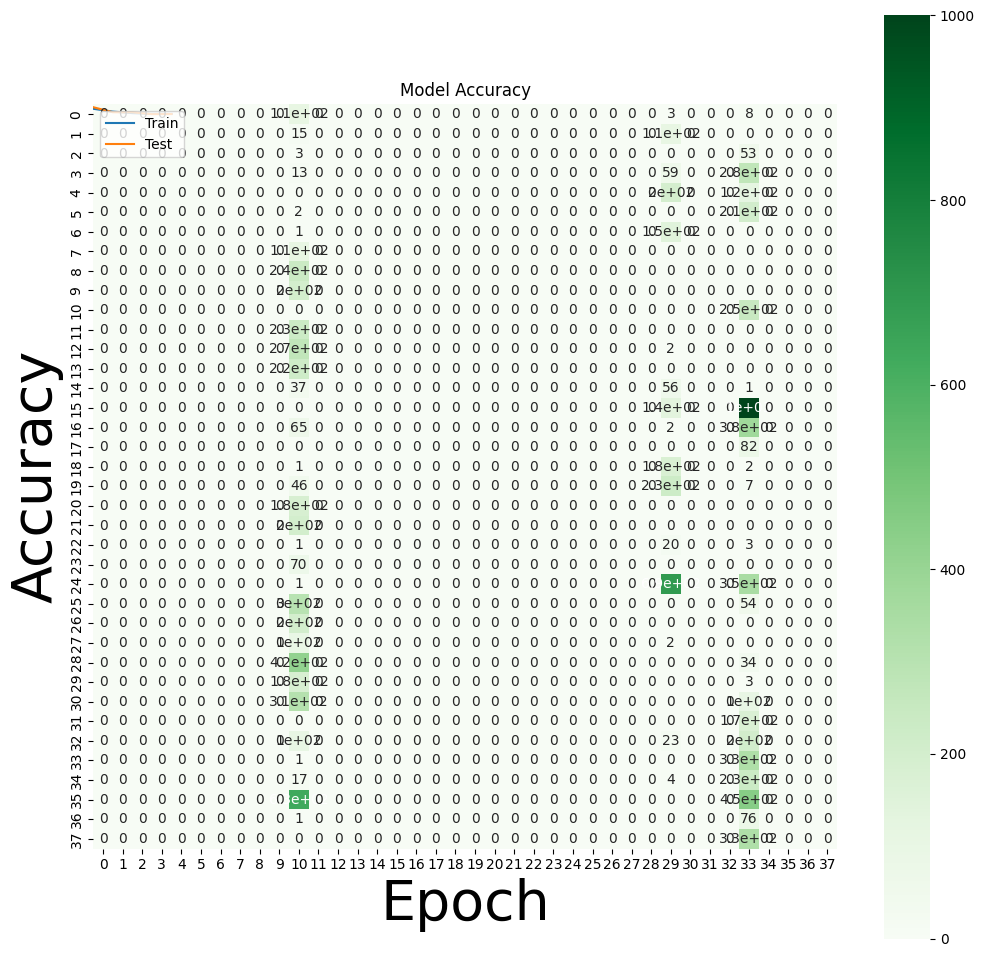

In [67]:
cm = confusion_matrix(true_labels,predicted_labels2)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [16]:
model3 = tf.keras.models.clone_model(model)
model3.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.001) ,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
history3 = model3.fit(train, epochs=15, validation_data=test,steps_per_epoch = int(0.5*len(train)))

Epoch 1/15
679/679 [==============================] - 172s 201ms/step - loss: 2.8963 - accuracy: 0.2822 - val_loss: 2.6810 - val_accuracy: 0.3147
Epoch 2/15
679/679 [==============================] - 135s 199ms/step - loss: 1.9005 - accuracy: 0.4820 - val_loss: 2.1684 - val_accuracy: 0.4209
Epoch 3/15
679/679 [==============================] - 19s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.1684 - val_accuracy: 0.4209


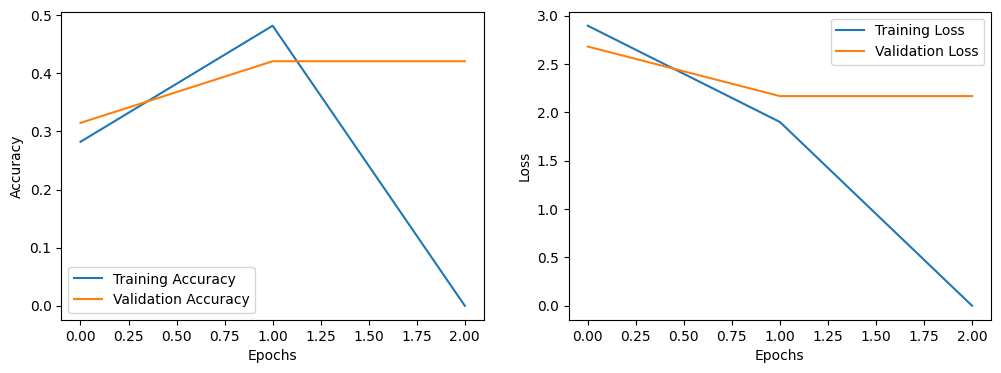

In [58]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
model4 = tf.keras.models.clone_model(model)
model4.compile(optimizer =tf.keras.optimizers.legacy.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
history4 = model4.fit(train, epochs=15, validation_data=test,steps_per_epoch = int(0.75*len(train)),validation_steps=int(0.5*len(test)))

Epoch 1/15
1018/1018 [==============================] - 190s 179ms/step - loss: 2.6397 - accuracy: 0.3303 - val_loss: 2.9531 - val_accuracy: 0.4770
Epoch 2/15
1018/1018 [==============================] - 68s 66ms/step - loss: 1.7618 - accuracy: 0.5063 - val_loss: 2.7855 - val_accuracy: 0.3307


In [21]:
from tensorflow.keras.applications import InceptionV3

inception_base = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))

87910968/87910968 [==============================] - 3s 0us/step


In [22]:
for layer in inception_base.layers:
    layer.trainable = True

In [25]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255,input_shape=(224,224,3)),
    
    inception_base,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(38,activation='sigmoid')
])

In [26]:
model5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_98 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [28]:
model5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [29]:
history5 = model5.fit(train, epochs=10, validation_data=test,callbacks=[early_stopping])

Epoch 1/10
1358/1358 [==============================] - 250s 157ms/step - loss: 3.0709 - accuracy: 0.1746 - val_loss: 3.7920 - val_accuracy: 0.0530
Epoch 2/10
1358/1358 [==============================] - 208s 153ms/step - loss: 2.6318 - accuracy: 0.2382 - val_loss: 2.7893 - val_accuracy: 0.2555
Epoch 3/10
1358/1358 [==============================] - 208s 153ms/step - loss: 1.9482 - accuracy: 0.4088 - val_loss: 2.1650 - val_accuracy: 0.4314
Epoch 4/10
1358/1358 [==============================] - 208s 153ms/step - loss: 1.5459 - accuracy: 0.5270 - val_loss: 1.5178 - val_accuracy: 0.5592
Epoch 5/10
1358/1358 [==============================] - 210s 154ms/step - loss: 1.2490 - accuracy: 0.6163 - val_loss: 2.5630 - val_accuracy: 0.3945
Epoch 6/10
1358/1358 [==============================] - 209s 154ms/step - loss: 1.0416 - accuracy: 0.6786 - val_loss: 1.1477 - val_accuracy: 0.6574
Epoch 7/10
1358/1358 [==============================] - 209s 154ms/step - loss: 0.8825 - accuracy: 0.7275 - val_

In [32]:
initial_epochs = 10
history5_1 = model5.fit(train,epochs = initial_epochs+5,initial_epoch = history5.epoch[-1],validation_data=test,callbacks=[early_stopping])

Epoch 10/15
1358/1358 [==============================] - 208s 153ms/step - loss: 0.2894 - accuracy: 0.9161 - val_loss: 0.5782 - val_accuracy: 0.8536
Epoch 11/15
1358/1358 [==============================] - 208s 153ms/step - loss: 0.2610 - accuracy: 0.9235 - val_loss: 0.8500 - val_accuracy: 0.7946
Epoch 12/15
1358/1358 [==============================] - 208s 153ms/step - loss: 0.2443 - accuracy: 0.9280 - val_loss: 0.6429 - val_accuracy: 0.8429
Epoch 13/15
1358/1358 [==============================] - 208s 153ms/step - loss: 0.2247 - accuracy: 0.9351 - val_loss: 1.9707 - val_accuracy: 0.6613
Epoch 14/15
1358/1358 [==============================] - 208s 153ms/step - loss: 0.2167 - accuracy: 0.9358 - val_loss: 0.1922 - val_accuracy: 0.9504
Epoch 15/15
1358/1358 [==============================] - 209s 154ms/step - loss: 0.1946 - accuracy: 0.9439 - val_loss: 0.2222 - val_accuracy: 0.9446


In [59]:
predictions5 = model5.predict(test)
predicted_labels5 = tf.argmax(predictions5,axis=1)
print(classification_report(true_labels, predicted_labels5))

340/340 [==============================] - 17s 44ms/step
              precision    recall  f1-score   support

           0       0.51      0.93      0.66       120
           1       0.26      0.77      0.39       124
           2       0.09      0.96      0.17        56
           3       0.32      0.87      0.47       348
           4       0.83      0.64      0.72       318
           5       0.10      0.50      0.17       208
           6       0.10      0.47      0.17       147
           7       0.19      0.96      0.32       109
           8       0.46      0.09      0.15       238
           9       0.12      0.02      0.03       200
          10       0.01      0.01      0.01       247
          11       0.31      0.39      0.34       229
          12       0.00      0.00      0.00       274
          13       0.94      0.70      0.80       219
          14       0.54      0.85      0.66        94
          15       0.98      0.59      0.73      1137
          16       1.00 

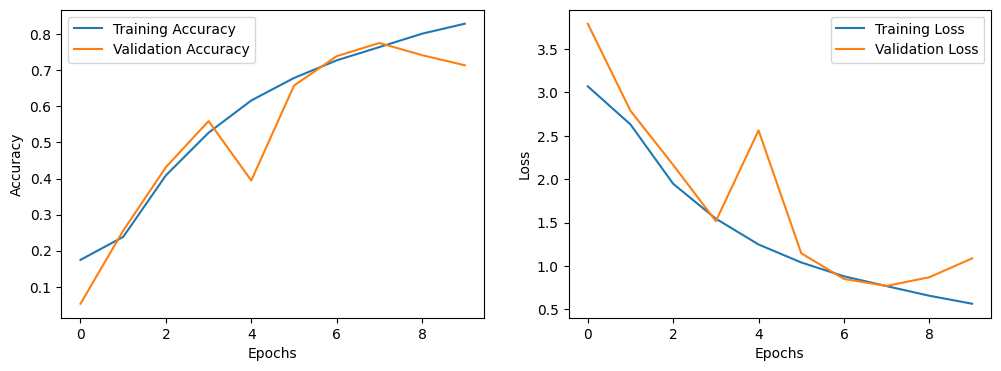

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [61]:
ploh5 = tf.one_hot(predicted_labels5, depth=38)
roc_auc5 = roc_auc_score(tloh,ploh5, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc5)

ROC AUC SCORE:  0.7541152851374798


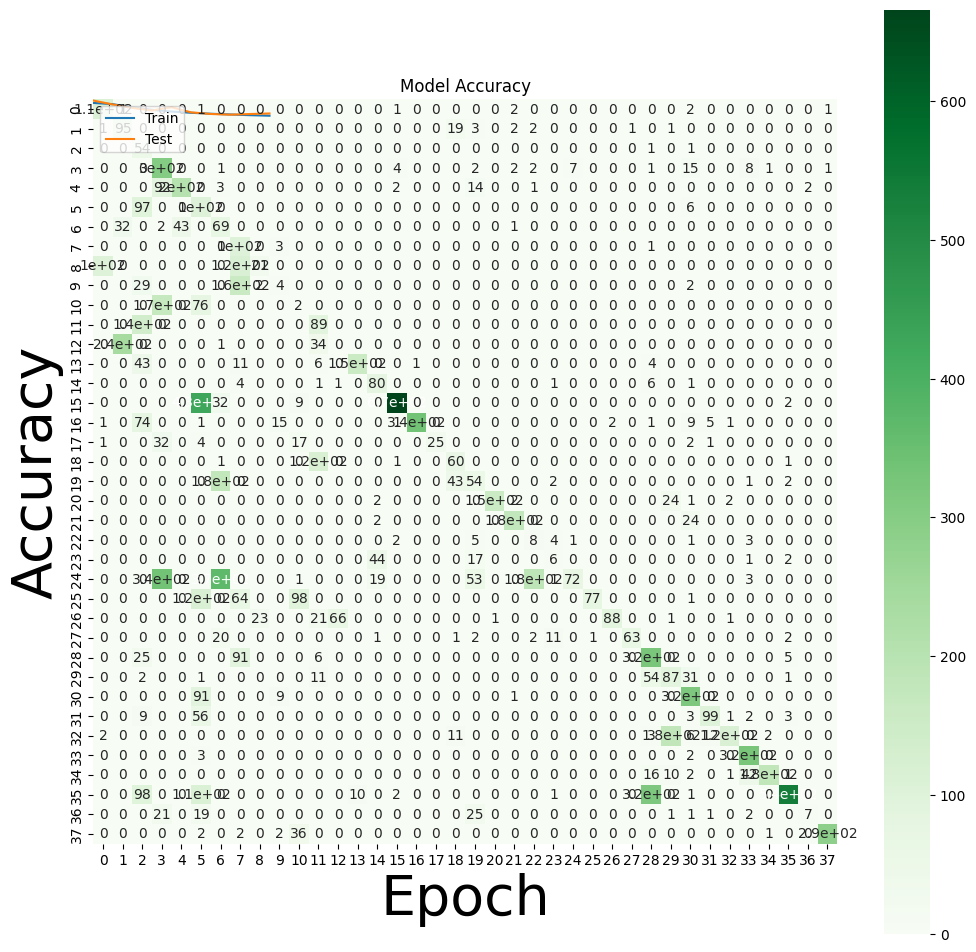

In [68]:
cm = confusion_matrix(true_labels,predicted_labels5)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [33]:
mobilenet_base = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False,input_shape=(224,224,3))

17225924/17225924 [==============================] - 1s 0us/step


In [34]:
for layer in mobilenet_base.layers:
    layer.trainable = True

In [35]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1/255,input_shape=(224,224,3)),
    
    mobilenet_base,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(38,activation='sigmoid')
])

In [36]:
model6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization_100 (B  (None, 128)               512       
 atchNormalization)                                              
                                                      

In [37]:
model6.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [38]:
history6 = model6.fit(train,epochs = 10 ,validation_data=test,callbacks=[early_stopping])

Epoch 1/10
1358/1358 [==============================] - 119s 82ms/step - loss: 2.5772 - accuracy: 0.3553 - val_loss: 1.1217 - val_accuracy: 0.7783
Epoch 2/10
1358/1358 [==============================] - 109s 80ms/step - loss: 1.5288 - accuracy: 0.6063 - val_loss: 0.7374 - val_accuracy: 0.8639
Epoch 3/10
1358/1358 [==============================] - 110s 81ms/step - loss: 1.1913 - accuracy: 0.7001 - val_loss: 0.5428 - val_accuracy: 0.8978
Epoch 4/10
1358/1358 [==============================] - 110s 81ms/step - loss: 0.9892 - accuracy: 0.7550 - val_loss: 0.4232 - val_accuracy: 0.9202
Epoch 5/10
1358/1358 [==============================] - 110s 81ms/step - loss: 0.8595 - accuracy: 0.7904 - val_loss: 0.3390 - val_accuracy: 0.9367
Epoch 6/10
1358/1358 [==============================] - 110s 81ms/step - loss: 0.7550 - accuracy: 0.8156 - val_loss: 0.2779 - val_accuracy: 0.9476
Epoch 7/10
1358/1358 [==============================] - 110s 81ms/step - loss: 0.6727 - accuracy: 0.8371 - val_loss: 0

In [62]:
predictions6 = model6.predict(test)
predicted_labels6 = tf.argmax(predictions6,axis=1)
print(classification_report(true_labels, predicted_labels6))

340/340 [==============================] - 10s 27ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       120
           1       0.99      0.95      0.97       124
           2       1.00      0.73      0.85        56
           3       0.99      1.00      0.99       348
           4       1.00      1.00      1.00       318
           5       0.99      0.98      0.99       208
           6       1.00      1.00      1.00       147
           7       0.91      0.73      0.81       109
           8       1.00      1.00      1.00       238
           9       0.87      0.94      0.91       200
          10       0.99      1.00      1.00       247
          11       0.99      0.97      0.98       229
          12       0.97      0.99      0.98       274
          13       1.00      1.00      1.00       219
          14       1.00      0.98      0.99        94
          15       1.00      1.00      1.00      1137
          16       0.97 

In [65]:
ploh6 = tf.one_hot(predicted_labels6, depth=38)
roc_auc6 = roc_auc_score(tloh,ploh6, average='macro')
#receiver operating characteristic curve
print("ROC AUC SCORE: ",roc_auc6)

ROC AUC SCORE:  0.9611746474220012


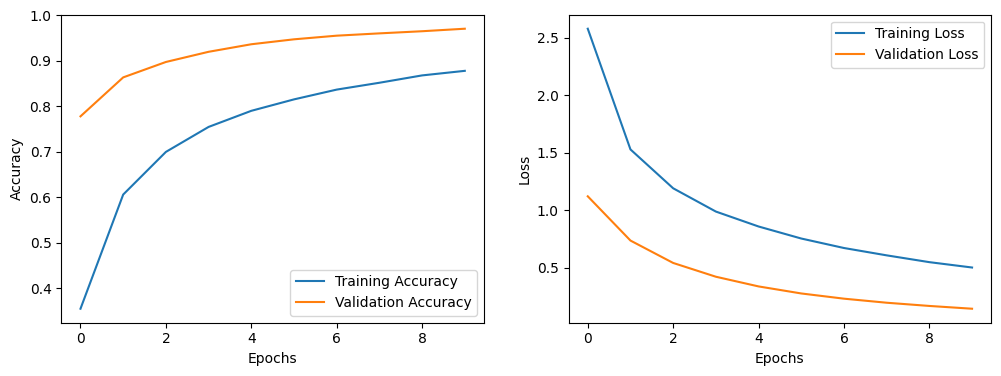

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

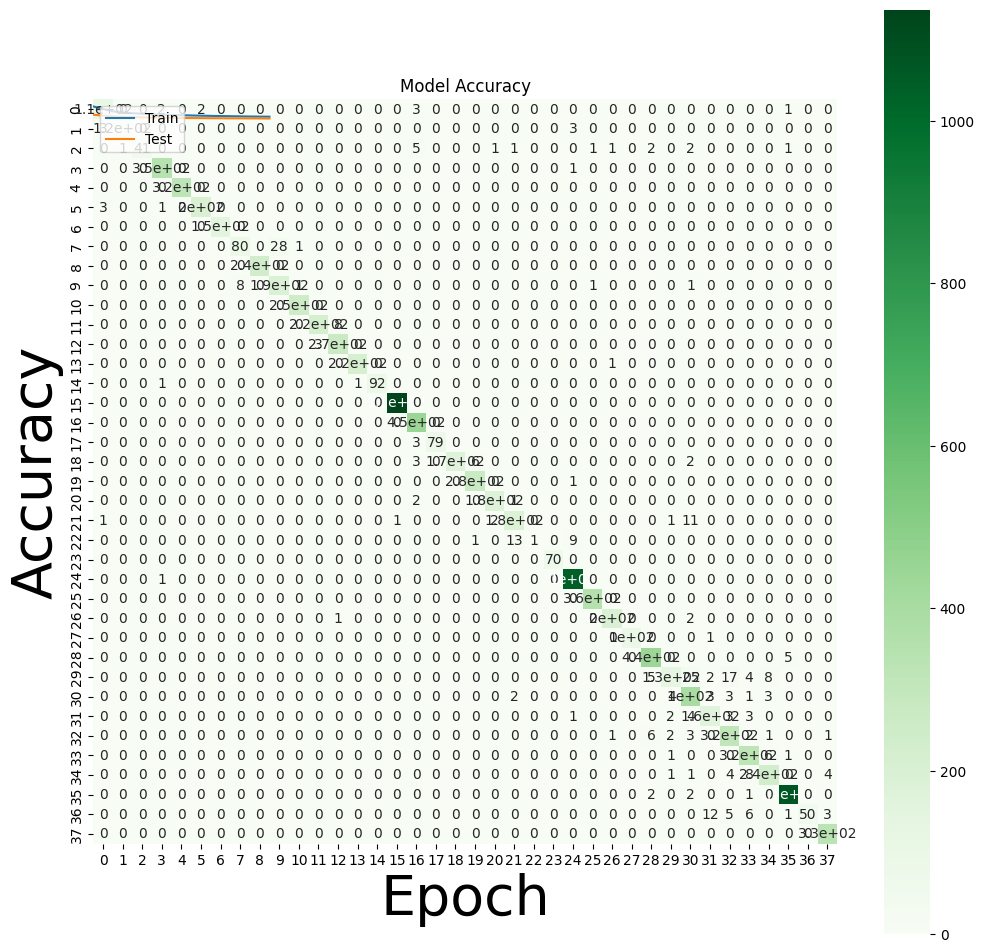

In [69]:
cm = confusion_matrix(true_labels,predicted_labels6)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [40]:
model7 = tf.keras.models.clone_model(model6)

In [45]:
model7.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [46]:
history7 = model7.fit(train,epochs=15,validation_data=test,callbacks=[early_stopping],steps_per_epoch = int(0.5*len(train)))

Epoch 1/15
679/679 [==============================] - 67s 89ms/step - loss: 2.7750 - accuracy: 0.3178 - val_loss: 2.3092 - val_accuracy: 0.4241
Epoch 2/15
679/679 [==============================] - 60s 88ms/step - loss: 2.5562 - accuracy: 0.3677 - val_loss: 2.3449 - val_accuracy: 0.4159
Epoch 3/15
679/679 [==============================] - 10s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 2.3449 - val_accuracy: 0.4159


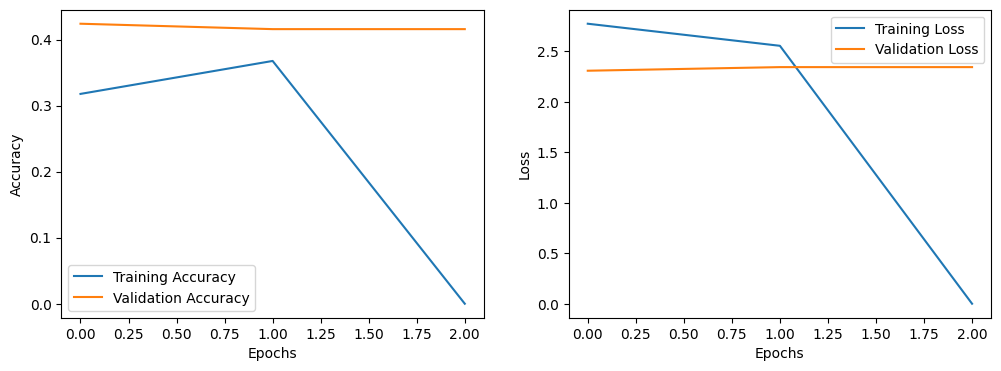

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()